# Setup

In [2]:
from utils import *

# Load data

## Zones
Compute the centroids to be exported.

In [2]:
zones = pd.read_parquet(
    'data/geometry/zones.parquet',
    columns=['geoid', 'level', 'city', 'county', 'popu', 'labor'])
centroids = (pd.read_parquet(
    'data/geometry/centroids.parquet',
    columns=['geoid', 'x', 'y'])
             .rename(columns=D(x='lon', y='lat')))
zones = view(zones.merge(centroids, on='geoid'))

143,971 rows x 8 cols; Memory: 11.1 MiB


,geoid,level,city,county,popu,labor,lon,lat
,<object>,<category>,<category>,<category>,<int32>,<int32>,<float32>,<float32>
0,42007,County,Pittsburgh,Beaver,164781,84153,-80.349266,40.682495


## Opportunities

In [3]:
opport = view(pd.read_parquet('data/opport/opportunities.parquet')
              .astype(D(level=CAT)))

1,988,736 rows x 4 cols; Memory: 45.5 MiB


,geoid,level,kind,opport
,<category>,<category>,<category>,<int32>
0,010010201001,BG,Jobs: All,145


## Impedance weights
The impedance function used in this study is the power exponential: $f(x)=\exp({\alpha x^\beta})$. The parameters $\alpha$ and $\beta$ were determined from the NHTS data (as part of the impedance paper under review in JTRG). These are carried over directly here:

In [4]:
imped_params = view(Pdf([
    ('Drive',   'Work',     -0.007127, 1.501453),
    ('Drive',   'Non-work', -0.020097, 1.361630),
    ('Walk',    'Work',     -0.053588, 1.085346),
    ('Walk',    'Non-work', -0.058269, 1.007449),
    ('Bike',    'Work',     -0.007653, 1.591415),
    ('Bike',    'Non-work', -0.028080, 1.145222),
], columns=['mode', 'purpose', 'α', 'β']).astype(D(α=F32, β=F32)))

6 rows x 4 cols; Memory: 0.0 MiB


,mode,purpose,α,β
,<object>,<object>,<float32>,<float32>
0,Drive,Work,-0.007127,1.501453


# Prepare data

## Compute access
<!-- - Impedance weight: $$ w_{i,j}^{k,m} = f_{k,m}(t_{m,i,j}) = t_{m,i,j}^{\alpha_{k,m}} e^{\beta_{k,m} t_{m,i,j}} $$ -->
- Impedance weight: $$ w_{i,j}^{k,m} = f_{k,m}(t_{m,i,j}) = \exp\left(\alpha_{k,m}\cdot t_{m,i,j}^{\beta_{k,m}}\right) $$
- **Contour** (cumulative opportunities): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} o_j^k $$
- **Gravity**: $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} o_j^k\cdot w_{i,j}^{k,m} $$
- **E2SFCA** (Enhanced 2-Step Floating Catchment Area): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} \frac{o_j^k}{\sum_{l\in C_j(t)} p_j^k\cdot w_{l,j}^{k,m}} $$
- **M2SFCA** (Modified 2-Step Floating Catchment Area): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} \frac{o_j^k\cdot w_{i,j}^{k,m}}{\sum_{l\in C_j(t)} p_j^k\cdot w_{l,j}^{k,m}} $$
<!-- - **XMFCA** (Multi-Modal Floating Catchment Area): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} \frac{o_j^k\cdot w_{i,j}^{k,m}}{\sum_{l\in C_j(t)} p_j^k\cdot \max_m (w_{l,j}^{k,m})} $$ -->

In [5]:
thresholds = (15, 30, 45, 60, 90) # travel time thresholds (minutes)

### Compute for one city

In [7]:
def get_access(city, opport=opport, zones=zones, params=imped_params,
               thresholds=thresholds, ttm_source='osrm'):
    city_ = city.lower().replace(' ', '-').replace('.', '')
    zones = filt(zones, city=city)[['geoid', 'popu', 'labor']]
    kinds = sorted(set(opport.kind))
    # convert opportunities table from long to wide format for efficient processing
    opport = (opport.merge(zones['geoid'])
              .pivot_table('opport', 'geoid', 'kind', observed=True)
              .fillna(0).astype(F32).rename(columns=lambda x: 'opport=' + x))
    opport = zones.merge(opport, on='geoid')
    all_access = []
    for mode in ['Bike', 'Drive', 'Walk']: # for each mode
        for level in ['County', 'Tract', 'BG']: # for each spatial level
            # load the travel time OD matrix table
            fpath = f'data/ttm/{ttm_source}/{city_}_{mode.lower()}_{level.lower()}.parquet'
            od = pd.read_parquet(fpath, columns=['src', 'trg', 'time'])
            od.time /= 60 # convert time from seconds to minutes
            # assign the target zone the opportunity counts
            od = od.merge(opport.rename(columns=D(geoid='trg'))
                          .astype(D(trg=od.trg.dtype)).dropna(subset='trg'), on='trg')
            # compute the impedance weight & catchment demand potential by trip purpose
            for purpose, dmd_col in [('Work', 'labor'), ('Non-work', 'popu')]:
                α, β = filt(params, mode=mode, purpose=purpose).iloc[0]
                wts = od[f'weight={purpose}'] = np.exp(α * od.time ** β, dtype=F32)
                od[f'dmd={purpose}'] = (od.pop(dmd_col) * wts).astype(F32)
            # compute supply potential (numerator) for each opportunity kind
            for k in kinds:
                purpose = 'Work' if k.startswith('Jobs') else 'Non-work'
                od[f'supply={k}'] = od[f'opport={k}'] * od[f'weight={purpose}']
            for thresh in np.sort(thresholds)[::-1]: # for each travel time threshold
                # filter the travel time OD matrix by threshold (in place)
                od = od[od.time <= thresh]
                # compute total demand potential of each destination zone (denominator)
                total_dmd = (od.groupby('trg', observed=True)
                             [['dmd=Work', 'dmd=Non-work']].sum()
                             .pipe(lambda df: df[df.ne(0).all(axis=1)])
                             .rename(columns=lambda x: 'tot_' + x))
                od = (od.drop(columns=total_dmd.columns, errors='ignore')
                      .merge(total_dmd, on='trg'))
                # compute the FCA ratio metrics: M2SFCA and E2SFCA
                for k in kinds:
                    purpose = 'Work' if k.startswith('Jobs') else 'Non-work'
                    od[f'E2SFCA={k}'] = od[f'opport={k}'] / od[f'tot_dmd={purpose}']
                    od[f'M2SFCA={k}'] = od[f'supply={k}'] / od[f'tot_dmd={purpose}']
                # compute the access metrics by summing values over the origin zones
                group_src = od.groupby('src', observed=True)
                for measure, col in [('Contour', 'opport'), ('Gravity', 'supply'),
                                     ('E2SFCA', 'E2SFCA'), ('M2SFCA', 'M2SFCA')]:
                    xs = (group_src[[f'{col}={k}' for k in kinds]].sum()
                          .rename(columns=lambda x: x.split('=')[1])
                          .reset_index().rename(columns=D(src='geoid'))
                          .melt('geoid', var_name='kind', value_name='access')
                          .assign(measure=measure, mode=mode, thresh=str(thresh), level=level))
                    all_access.append(xs)
    # aggregate and compress all the access metrics in one table
    cols = D(measure=CAT, kind=CAT, mode=CAT, thresh=CAT, level=CAT, geoid=CAT, access=F32)
    all_access = (pd.concat(all_access).query('access > 0')
                  .reset_index(drop=True).astype(cols)[list(cols)])
    return all_access

xs = view(get_access('Buffalo'))

787,676 rows x 7 cols; Memory: 8.4 MiB


,measure,kind,mode,thresh,level,geoid,access
,<category>,<category>,<category>,<category>,<category>,<category>,<float32>
0,Contour,EVCI: Fast DC,Bike,90,County,36029,85.0


### Compute for all cities

In [10]:
def compute_access(city, overwrite=False):
    city_ = city.lower().replace(' ', '-').replace('.', '')
    outpath = mkdir('data/access/saa') / f'{city_}.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    t = dt.datetime.now()
    print(f'[{t.strftime("%m/%d %I:%M %p")}] Processing {city}', end=': ')
    xs = get_access(city)
    xs.to_parquet(outpath)
    mins, sec = divmod((dt.datetime.now() - t).total_seconds(), 60)
    print(f'runtime: {mins:.0f}m{sec:.0f}s')

# for city in tqdm(sorted(set(zones.city) - {'Los Angeles', 'New York'})):
#     compute_access(city) # 16m46s
# compute_access('Los Angeles') # 4m52s
# compute_access('New York') # 18m25s

## Export data
Convert the access data for each city and level into wide format to save space in CSV format. This involves converting all combinations of (metric, opportunity kind, mode, threshold) into one column each so that each row denotes a unique zone.

In [11]:
measures = D(Contour='Co', Gravity='Gr', E2SFCA='E2', M2SFCA='M2')
modes = D(Drive='Dr', Bike='Bi', Walk='Wa')
thresh = [f'{t} min' for t in thresholds]
kinds = D(
    jobTot='Jobs: All',
    jobEdu='Jobs: Low edu',
    jobWag='Jobs: Low wage',
    jobPOC='Jobs: POC',
    poiTot='POIs: All',
    poiEdu='POIs: Education',
    poiGro='POIs: Groceries',
    poiMed='POIs: Medical',
    poiSoc='POIs: Social Support',
    evStat='EVCI: Stations',
    evseL2='EVCI: Level 2',
    evseDC='EVCI: Fast DC',
)
fields = Pdf(list(it.product(measures, kinds.values(), modes, thresh)),
             columns=['measure', 'kind', 'mode', 'thresh'])
fields = fields[~((fields.kind.str[:4] == 'EVCI') & (fields['mode'] != 'Drive'))]
fields.insert(0, 'field', fields.measure.map(measures) + '_' +
              fields.kind.map({v: k for k, v in kinds.items()}) + '_' + 
              fields['mode'].map(modes) + '_' + 
              fields.thresh.str.removesuffix(' min'))
view(fields).to_csv('data/export/access_metrics.csv', index=False)

600 rows x 5 cols; Memory: 0.2 MiB


,field,measure,kind,mode,thresh
,<object>,<object>,<object>,<object>,<object>
0,Co_jobTot_Dr_15,Contour,Jobs: All,Drive,15 min


In [12]:
zone_info = zones['geoid level county lat lon popu labor'.split()].copy()
for col, kind in D(njobs='Jobs: All', npois='POIs: All', nevcs='EVCI: Stations').items():
    df = filt(opport, kind=kind).rename(columns=D(opport=col))
    zone_info = zone_info.merge(df, 'left', on=('geoid', 'level'))
    zone_info[col] = zone_info[col].fillna(0).astype(I32)
view(zone_info);

143,980 rows x 10 cols; Memory: 12.6 MiB


,geoid,level,county,lat,lon,popu,labor,njobs,npois,nevcs
,<object>,<category>,<category>,<float32>,<float32>,<int32>,<int32>,<int32>,<int32>,<int32>
0,42007,County,Beaver,40.682495,-80.349266,164781,84153,52019,1270,9


In [13]:
for file in (pbar := tqdm(sorted(glob('data/access/saa/*')))):
    city = file.split('/')[-1].split('.')[0]
    pbar.set_description(city)
    df = pd.read_parquet(file)
    df.thresh = df.thresh.astype(str) + ' min'
    df = df.merge(fields.astype(D(
        measure=df.measure.dtype, kind=df.kind.dtype,
        mode=df['mode'].dtype, thresh=df.thresh.dtype)))
    df = df.pivot_table('access', 'geoid', 'field', observed=True)
    df = zone_info.merge(df.fillna(0), on='geoid').reset_index(drop=True)
    outpath = mkdir('data/export/access') / f'{city}.csv.gz'
    df.to_csv(outpath, index=False, compression='gzip') # 5m54s

  0%|          | 0/50 [00:00<?, ?it/s]

# Visualize

## Fig: Access vs population density

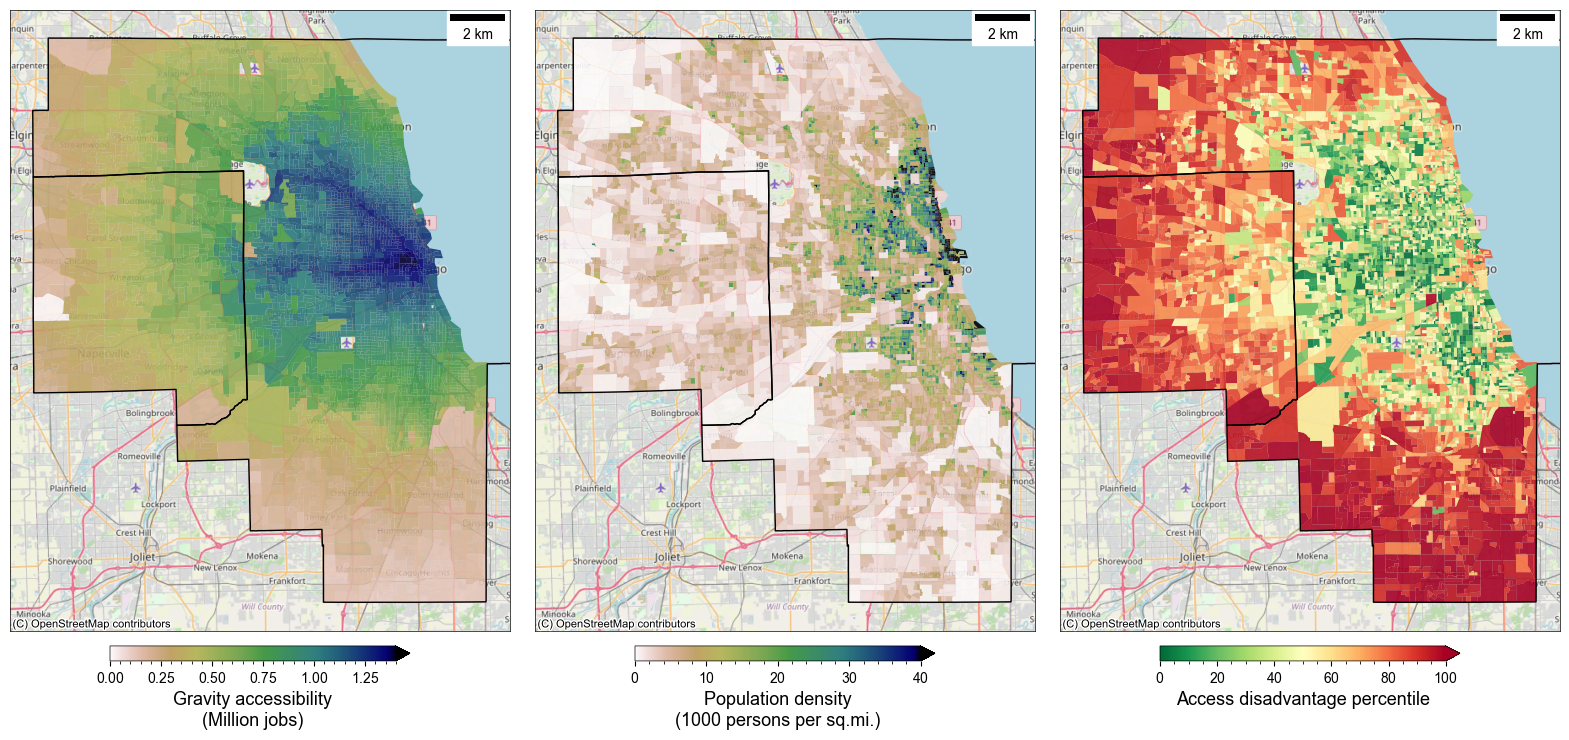

In [12]:
zones = gpd.read_parquet('data/geometry/zones.parquet',
                         filters=[('city', '==', 'Chicago')])
zones = zones[zones.county.isin(['Cook', 'DuPage'])].to_crs(CRS_M)
zones['pop_density'] = (zones.popu / zones.aland) / 1000
xs = pd.read_parquet('data/access/saa/chicago.parquet')
xs = filt(xs, level='BG', measure='Gravity', kind='Jobs: All',
          mode='Drive', thresh='30')
xs = zones.merge(xs, on='geoid')
xs.access /= 1e6 # no. of jobs in millions
xs['rank'] = (xs.popu / xs.access).rank(pct=True) * 100
_, axes = plt.subplots(1, 3, figsize=(20, 10), dpi=100)
for i, (col, label, vmax, cmap) in enumerate([
    ('access', 'Gravity accessibility\n(Million jobs)', 1.4, 'gist_earth_r'),
    ('pop_density', 'Population density\n(1000 persons per sq.mi.)', 40, 'gist_earth_r'),
    ('rank', 'Access disadvantage percentile', 100, 'RdYlGn_r'),
]):
    ax = maplot(xs, col, ax=axes[i], label=label, vmin=0, vmax=vmax,
                vert=False, shrink=0.6, cbar_kw=D(pad=0.02, extend='max'),
                alpha=0.9, cmap=cmap, bgmap_kw=D(source='OpenStreetMap.Mapnik'))
    filt(zones, level='County').plot(ax=ax, fc='none', ec='k', lw=1)
plt.subplots_adjust(wspace=0.05)
imsave('Access vs population density in Chicago') # 13s